### **Event Study on the Effect of Private Placements: EMH Verification**

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat July 18 00:47:01 2021

@author: Bradley

Code for recurring FIN3080 Project 3
"""

'\nCreated on Sat July 18 00:47:01 2021\n\n@author: Bradley\n\nCode for recurring FIN3080 Project 3\n'

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 

**定向增发事件数据处理**

In [2]:
# 研究对象：2010年1月到2019年12月全体A股定向增发事件
# date: 事件的declaration date
# 需剔除ST股和金融类上市公司，不适合做事件研究，分类标准使用CSMAR

event = pd.read_csv('./raw_data/ER_Private.csv')
event = event[event['SecurityType'] == 'A']
event = event[['Stock Code', 'ShortName', 'FullName', 'DeclareDate']]
event.columns = ['code', 'short', 'full', 'date']
event['date'] = pd.to_datetime(event['date'])
event['code'] = event['code'].map(lambda x: "%06d"%x)

# 仅保留2010年1月到2019年12月的事件数据
event['year'] = event['date'].dt.year
event = event[event['year'] >= 2010]
event = event[event['year'] <= 2019]
event = event.reset_index(drop=True)
event['event_id'] = event.index
event.pop('year')
event

0       2010
1       2012
2       2013
3       2014
4       2015
        ... 
5917    2017
5918    2018
5919    2019
5920    2019
5921    2019
Name: year, Length: 5922, dtype: int64

,code,short,full,date,event_id
0,000001,深发展A,深圳发展银行股份有限公司,2010-09-02,0
1,000001,平安银行,平安银行股份有限公司,2012-08-16,1
2,000001,平安银行,平安银行股份有限公司,2013-09-09,2
3,000001,平安银行,平安银行股份有限公司,2014-07-16,3
4,000001,平安银行,平安银行股份有限公司,2015-11-20,4
...,...,...,...,...,...
5917,603996,中新科技,中新科技集团股份有限公司,2017-12-19,5917
5918,603997,继峰股份,宁波继峰汽车零部件股份有限公司,2018-10-12,5918
5919,603997,继峰股份,宁波继峰汽车零部件股份有限公司,2019-04-01,5919
5920,688001,华兴源创,苏州华兴源创科技股份有限公司,2019-12-07,5920


In [3]:
event.isnull().sum()

code        0
short       0
full        0
date        0
event_id    0
dtype: int64

In [4]:
# 三因子日线数据
market = pd.read_csv('./raw_data/STK_MKT_THRFACDAY.csv')
market.columns = ['type', 'date', 'risk_premium', 'smb', 'hml']
market = market[market['type'] == 'P9714']
market.pop('type')
market['date'] = pd.to_datetime(market['date'])
market.set_index("date", inplace=True)
market

5        P9714
12       P9714
19       P9714
26       P9714
33       P9714
         ...  
64772    P9714
64782    P9714
64792    P9714
64802    P9714
64812    P9714
Name: type, Length: 7688, dtype: object

,risk_premium,smb,hml
date,,,
1990-12-19,2.473374,NaN,NaN
1990-12-20,0.038937,NaN,NaN
1990-12-21,0.032358,NaN,NaN
1990-12-24,0.040570,NaN,NaN
1990-12-25,0.041140,NaN,NaN
...,...,...,...
2022-03-17,0.016056,0.001099,-0.010972
2022-03-18,0.009992,0.002884,0.014053
2022-03-21,0.002822,0.016966,-0.003558


In [5]:
# 无风险利率
riskfree = pd.read_csv('./raw_data/TRD_Nrrate.csv')
riskfree.columns = ['type', 'date', 'riskfree']
riskfree.pop('type')
riskfree['date'] = pd.to_datetime(riskfree['date'])
riskfree.set_index("date", inplace=True)
riskfree

0        NRI01
1        NRI01
2        NRI01
3        NRI01
4        NRI01
         ...  
11417    NRI01
11418    NRI01
11419    NRI01
11420    NRI01
11421    NRI01
Name: type, Length: 11422, dtype: object

,riskfree
date,
1990-04-15,0.0263
1990-08-21,0.0227
1990-12-19,0.0227
1990-12-20,0.0227
1990-12-21,0.0227
...,...
2022-03-21,0.0041
2022-03-22,0.0041
2022-03-23,0.0041


In [6]:
# 设置事件检验法超参数
event_window = 10 #取事件前后各event_window的时间作为事件窗
test_window = 60 #事件窗前test_window的时间作为训练窗

**首先以任一事件为例展示研究过程**

In [337]:
event.head(10)

,code,short,full,date,event_id
0,000001,深发展A,深圳发展银行股份有限公司,2010-09-02,0
1,000001,平安银行,平安银行股份有限公司,2012-08-16,1
2,000001,平安银行,平安银行股份有限公司,2013-09-09,2
3,000001,平安银行,平安银行股份有限公司,2014-07-16,3
4,000001,平安银行,平安银行股份有限公司,2015-11-20,4
5,000002,万科A,万科企业股份有限公司,2016-07-02,5
6,000004,国农科技,深圳中国农大科技股份有限公司,2014-09-16,6
7,000004,国农科技,深圳中国农大科技股份有限公司,2019-04-10,7
8,000005,世纪星源,深圳世纪星源股份有限公司,2015-05-09,8
9,000005,世纪星源,深圳世纪星源股份有限公司,2015-05-09,9


In [358]:
root = 'D:\\self_learning_python\\Project\\Real_time_stock_data_update\\all_stock_data\\stock_daily'

# 000002万科A为例
event1 = event.iloc[5]

# 深交所
if (event1['code'][0] == '0') or (event1['code'][0] == '3'):
    data = pd.read_csv(root+"\\sz"+event1['code']+".csv", encoding='gbk', skiprows=[0])

# 北交所
if (event1['code'][0] == '4') or (event1['code'][0] == '8'):
    data = pd.read_csv(root+"\\bj"+event1['code']+".csv", encoding='gbk', skiprows=[0])

# 上交所
if (event1['code'][0] == '7'):
    data = pd.read_csv(root+"\\sh"+event1['code']+".csv", encoding='gbk', skiprows=[0])

data.columns = ['code', 'name', 'date', 'open', 'high', 'low', 'close', 'pre_close', 'volume', 'notional', 'c_mv', 'mv']
data['return'] = data['close']/data['pre_close'] - 1
data

,code,name,date,open,high,low,close,pre_close,volume,notional,c_mv,mv,return
0,sz000002,深万科Ａ,1991-01-03,15.39,15.39,15.39,15.39,15.63,4500.0,3.510000e+05,4.322435e+08,6.361099e+08,-0.015355
1,sz000002,深万科Ａ,1991-01-04,15.31,15.31,15.31,15.31,15.39,6800.0,5.200000e+05,4.299967e+08,6.328033e+08,-0.005198
2,sz000002,深万科Ａ,1991-01-07,15.47,15.47,15.47,15.47,15.31,7300.0,5.690000e+05,4.344904e+08,6.394166e+08,0.010451
3,sz000002,深万科Ａ,1991-01-09,15.31,15.31,15.31,15.31,15.47,3200.0,2.460000e+05,4.299967e+08,6.328033e+08,-0.010343
4,sz000002,深万科Ａ,1991-01-10,15.23,15.23,15.23,15.23,15.31,300.0,2.100000e+04,4.277498e+08,6.294967e+08,-0.005225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,sz000002,万 科Ａ,2021-12-29,19.65,19.81,19.36,19.38,19.68,58214420.0,1.135709e+09,1.883262e+11,2.252999e+11,-0.015244
7303,sz000002,万 科Ａ,2022-01-04,19.49,20.65,19.36,20.49,19.76,194720202.0,3.956476e+09,1.991127e+11,2.382041e+11,0.036943
7304,sz000002,万 科Ａ,2022-01-05,20.43,21.61,20.36,21.17,20.49,193045791.0,4.075048e+09,2.057206e+11,2.461094e+11,0.033187
7305,sz000002,万 科Ａ,2022-01-06,21.12,21.66,20.79,21.05,21.17,138027406.0,2.923511e+09,2.045545e+11,2.447143e+11,-0.005668


In [359]:
data['date'] = pd.to_datetime(data['date'])
date = event1['date']
# 拼接事件窗和测试窗
total = data[data['date'] < date].tail(test_window+event_window).append(data[data['date'] >= date].head(1+event_window))
test = total.head(test_window)
test.tail()

,code,name,date,open,high,low,close,pre_close,volume,notional,c_mv,mv,return
5960,sz000002,万科Ａ,2015-11-30,14.29,15.25,14.28,15.07,14.26,202000999.0,3.029922e+09,1.467012e+11,1.665176e+11,0.056802
5961,sz000002,万科Ａ,2015-12-01,14.99,16.58,14.93,16.58,15.07,375016370.0,6.042685e+09,1.614006e+11,1.832025e+11,0.100199
5962,sz000002,万科Ａ,2015-12-02,16.68,18.24,16.54,18.24,16.58,638988613.0,1.133776e+10,1.775601e+11,2.015449e+11,0.100121
5963,sz000002,万科Ａ,2015-12-03,18.45,19.33,18.08,19.15,18.24,477123637.0,8.914672e+09,1.864362e+11,2.116176e+11,0.049890
5964,sz000002,万科Ａ,2015-12-04,18.90,19.84,18.60,18.98,19.15,376800949.0,7.225322e+09,1.847811e+11,2.097390e+11,-0.008877


In [360]:
test.set_index('date', inplace=True)
test[['risk_premium', 'smb', 'hml']] = market
test['riskfree'] = riskfree
test.head()

,code,name,open,high,low,close,pre_close,volume,notional,c_mv,mv,return,risk_premium,smb,hml,riskfree
date,,,,,,,,,,,,,,,,
2015-09-07,sz000002,万科Ａ,13.99,14.50,13.50,13.60,14.22,140058109.0,1.951783e+09,1.323803e+11,1.502637e+11,-0.043601,-0.027837,0.049959,-0.018565,0.0048
2015-09-08,sz000002,万科Ａ,13.54,13.68,13.30,13.68,13.60,65181113.0,8.800099e+08,1.331590e+11,1.511476e+11,0.005882,0.033150,0.030920,-0.016756,0.0048
2015-09-09,sz000002,万科Ａ,13.71,14.04,13.59,13.76,13.68,83457692.0,1.150245e+09,1.339377e+11,1.520315e+11,0.005848,0.027489,0.023549,-0.013193,0.0048
2015-09-10,sz000002,万科Ａ,13.63,13.79,13.51,13.54,13.76,41776819.0,5.696594e+08,1.317963e+11,1.496008e+11,-0.015988,-0.013973,-0.003356,0.001841,0.0048
2015-09-11,sz000002,万科Ａ,13.59,13.67,13.40,13.47,13.54,31345274.0,4.244002e+08,1.311149e+11,1.488274e+11,-0.005170,0.000689,0.016841,-0.012838,0.0048


In [361]:
def get_beta(df: pd.DataFrame, factors=['risk_premium']):
    X = df[factors].to_numpy()
    X = sm.add_constant(X)
    y = df['return'].to_numpy()
    model = sm.OLS(y, X)
    res = model.fit()
    return res.params[1:].tolist()

r, s, m = get_beta(test, factors=['risk_premium', 'smb', 'hml'])
total.set_index('date', inplace=True)
total[['risk_premium', 'smb', 'hml']] = market
total['riskfree'] = riskfree
total['risk_premium_loading'] = r
total['smb_loading'] = s
total['hml_loading'] = m

In [362]:
window = total.tail(event_window*2+1)
window.reset_index(inplace=True)
window.head()

,date,code,name,open,high,low,close,pre_close,volume,notional,c_mv,mv,return,risk_premium,smb,hml,riskfree,risk_premium_loading,smb_loading,hml_loading
0,2015-12-07,sz000002,万科Ａ,18.82,18.98,17.67,18.02,18.98,225571938.0,4.100197e+09,1.754350e+11,1.991305e+11,-0.050580,0.005363,0.014578,-0.007158,0.0041,0.973473,0.057808,1.286726
1,2015-12-08,sz000002,万科Ａ,17.90,18.07,17.40,17.77,18.02,152988606.0,2.702009e+09,1.730011e+11,1.963678e+11,-0.013873,-0.019663,0.001484,-0.001525,0.0041,0.973473,0.057808,1.286726
2,2015-12-09,sz000002,万科Ａ,17.95,19.55,17.81,19.55,17.77,359851973.0,6.732053e+09,1.903304e+11,2.160378e+11,0.100169,0.000582,-0.003806,-0.001311,0.0041,0.973473,0.057808,1.286726
3,2015-12-10,sz000002,万科Ａ,19.59,21.36,19.02,19.54,19.55,306737466.0,6.153428e+09,1.902330e+11,2.159273e+11,-0.000512,-0.004034,0.001156,-0.006598,0.0041,0.973473,0.057808,1.286726
4,2015-12-11,sz000002,万科Ａ,19.14,20.34,18.78,19.90,19.54,203500842.0,3.998320e+09,1.937378e+11,2.199054e+11,0.018424,-0.007042,-0.003369,-0.001339,0.0041,0.973473,0.057808,1.286726


In [363]:
def get_abnormal_return(s):
    normal_return = s['riskfree']
    normal_return += s['risk_premium']*s['risk_premium_loading']
    normal_return += s['smb']*s['smb_loading']
    normal_return += s['hml']*s['hml_loading']
    return s['return'] - normal_return

window['abnormal'] = window.apply(get_abnormal_return, axis=1)
window.head()

,date,code,name,open,high,low,close,pre_close,volume,notional,...,mv,return,risk_premium,smb,hml,riskfree,risk_premium_loading,smb_loading,hml_loading,abnormal
0,2015-12-07,sz000002,万科Ａ,18.82,18.98,17.67,18.02,18.98,225571938.0,4.100197e+09,...,1.991305e+11,-0.050580,0.005363,0.014578,-0.007158,0.0041,0.973473,0.057808,1.286726,-0.051533
1,2015-12-08,sz000002,万科Ａ,17.90,18.07,17.40,17.77,18.02,152988606.0,2.702009e+09,...,1.963678e+11,-0.013873,-0.019663,0.001484,-0.001525,0.0041,0.973473,0.057808,1.286726,0.003044
2,2015-12-09,sz000002,万科Ａ,17.95,19.55,17.81,19.55,17.77,359851973.0,6.732053e+09,...,2.160378e+11,0.100169,0.000582,-0.003806,-0.001311,0.0041,0.973473,0.057808,1.286726,0.097409
3,2015-12-10,sz000002,万科Ａ,19.59,21.36,19.02,19.54,19.55,306737466.0,6.153428e+09,...,2.159273e+11,-0.000512,-0.004034,0.001156,-0.006598,0.0041,0.973473,0.057808,1.286726,0.007738
4,2015-12-11,sz000002,万科Ａ,19.14,20.34,18.78,19.90,19.54,203500842.0,3.998320e+09,...,2.199054e+11,0.018424,-0.007042,-0.003369,-0.001339,0.0041,0.973473,0.057808,1.286726,0.023097


In [364]:
a = window['abnormal'].cumsum().values
np.hstack(([0], a))

array([ 0.        , -0.05153263, -0.04848823,  0.04892094,  0.05665942,
        0.07975604,  0.06154893,  0.11781149,  0.06940722,  0.14732086,
        0.24560006,  0.12333   ,  0.01275717,  0.00780304, -0.05149604,
       -0.04891374, -0.08453487, -0.12192517, -0.1196249 , -0.13681047,
       -0.15129094, -0.1809956 ])

<Figure size 576x360 with 0 Axes>

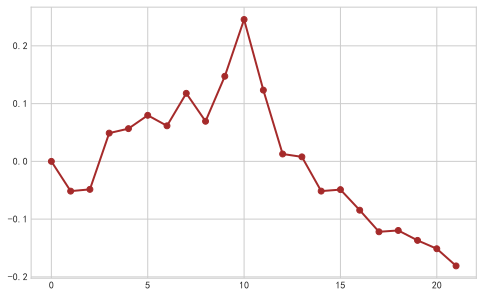

In [365]:
# 直接累加的算法计算CAR，arithmetic return

# 把计算的累积序列CAR一开始加上一个0，让累积收益从零开始
plt.figure(figsize=(8, 5))
cum_return = np.hstack(([0], window['abnormal'].cumsum().values))
plt.plot(cum_return, color='brown', marker='o')

<Figure size 576x360 with 0 Axes>

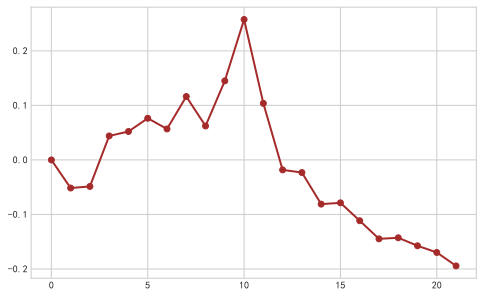

In [366]:
# 累乘的算法计算CAR，geometric return

# 把计算的累积序列CAR一开始加上一个0，让累积收益从零开始
plt.figure(figsize=(8, 5))
cum_return = np.hstack(([0], (1+window['abnormal']).cumprod().values-1))
plt.plot(cum_return, color='brown', marker='o')

**下面对全体事件进行处理**

In [7]:
# 从数据库中读取日线数据
root = 'D:\\self_learning_python\\Project\\Real_time_stock_data_update\\all_stock_data\\stock_daily'

def get_data(event):
    # 深交所
    if (event['code'][0] == '0') or (event['code'][0] == '3'):
        data = pd.read_csv(root+"\\sz"+event['code']+".csv", encoding='gbk', skiprows=[0])

    # 北交所
    if (event['code'][0] == '4') or (event['code'][0] == '8'):
        data = pd.read_csv(root+"\\bj"+event['code']+".csv", encoding='gbk', skiprows=[0])

    # 上交所
    if (event['code'][0] == '7'):
        data = pd.read_csv(root+"\\sh"+event['code']+".csv", encoding='gbk', skiprows=[0])

    data.columns = ['code', 'name', 'date', 'open', 'high', 'low', 'close', 'pre_close', 'volume', 'notional', 'c_mv', 'mv']
    data['return'] = data['close']/data['pre_close'] - 1
    return data

def get_beta(df: pd.DataFrame, factors=['risk_premium']):
    X = df[factors].to_numpy()
    X = sm.add_constant(X)
    y = df['return'].to_numpy()
    model = sm.OLS(y, X)
    res = model.fit()
    return res.params[1:].tolist()

def get_abnormal_return(s):
    normal_return = s['riskfree']
    normal_return += s['risk_premium']*s['risk_premium_loading']
    normal_return += s['smb']*s['smb_loading']
    normal_return += s['hml']*s['hml_loading']
    return s['return'] - normal_return

def event_study(event):
    data = get_data(event)
    date = event['date']
    data['date'] = pd.to_datetime(data['date'])
    
    # 拼接事件窗和测试窗
    total = data[data['date'] < date].tail(test_window+event_window).append(data[data['date'] >= date].head(1+event_window))
    test = total.head(test_window)

    # 合并因子数据
    test.set_index('date', inplace=True)
    test[['risk_premium', 'smb', 'hml']] = market
    test['riskfree'] = riskfree

    # 测试窗回归
    r, s, m = get_beta(test, factors=['risk_premium', 'smb', 'hml'])
    total.set_index('date', inplace=True)
    total[['risk_premium', 'smb', 'hml']] = market
    total['riskfree'] = riskfree
    total['risk_premium_loading'] = r
    total['smb_loading'] = s
    total['hml_loading'] = m

    # 事件窗
    window = total.tail(event_window*2+1)
    window.reset_index(inplace=True)

    window['abnormal'] = window.apply(get_abnormal_return, axis=1)

    # 取多列方便下面做分组分析，如果之前的数据已经对齐了有比如ROE, PB, PE等财务指标，那就在这里加上
    result = window[['date', 'abnormal', 'volume', 'notional', 'mv', 'c_mv']]
    return result

# 需要这个辅助函数
# 对于因为数据缺失等各种原因无法计算的，赋值为None
def try_study(event):
    try:
        result = event_study(event)
        return result
    except:
        return None

# 尝试几组事件
# a = event.iloc[:3]
# b = a.apply(event_study, axis=1)
# b.index
# result = pd.DataFrame(columns=['date', 'abnormal', 'event_id'])
# # result.columns = ['date', 'abnormal', 'event_id']
# for i in b.index:
#     frame = b.iloc[i]
#     frame['event_id'] = i
#     result = pd.concat([result, frame])

# 所有事件跑
calc = event.apply(try_study, axis=1)
calc

0                date  abnormal       volume      noti...
1                date  abnormal      volume     notion...
2                date  abnormal       volume      noti...
3                date  abnormal       volume      noti...
4                date  abnormal       volume      noti...
                              ...                        
5917                                                 None
5918                                                 None
5919                                                 None
5920                                                 None
5921                                                 None
Length: 5922, dtype: object

In [8]:
# 整理上面的apply结果
result = pd.DataFrame(columns=['date', 'abnormal', 'volume', 'notional', 'mv', 'c_mv', 'event_id'])
for i in calc.index:
    frame = calc.iloc[i]
    if frame is not None:
        frame['event_id'] = i
        result = pd.concat([result, frame])

result.to_csv("./processed_data/abnormal_return.csv", index=False, columns=['event_id', 'date', 'abnormal', 'volume', 'notional', 'mv', 'c_mv'])
result

,date,abnormal,volume,notional,mv,c_mv,event_id
0,2010-06-10,-0.016394,28464074.0,4.895631e+08,5.313397e+10,5.003172e+10,0
1,2010-06-11,-0.010944,20998339.0,3.622928e+08,5.325819e+10,5.014868e+10,0
2,2010-06-18,0.015981,44849256.0,7.852488e+08,5.378611e+10,5.064579e+10,0
3,2010-06-21,0.005336,58980712.0,1.063389e+09,5.682944e+10,5.351142e+10,0
4,2010-06-22,0.009125,41713771.0,7.704887e+08,5.754369e+10,5.418397e+10,0
...,...,...,...,...,...,...,...
16,2020-01-09,0.011149,2315501.0,1.192725e+08,5.161000e+09,1.290250e+09,3941
17,2020-01-10,0.001346,2415552.0,1.249473e+08,5.165000e+09,1.291250e+09,3941
18,2020-01-13,-0.000554,2320456.0,1.205098e+08,5.202000e+09,1.300500e+09,3941
19,2020-01-14,0.019503,4531454.0,2.405577e+08,5.346000e+09,1.336500e+09,3941


In [9]:
result = pd.read_csv("./processed_data/abnormal_return.csv")
result

,event_id,date,abnormal,volume,notional,mv,c_mv
0,0,2010-06-10,-0.016394,28464074.0,4.895631e+08,5.313397e+10,5.003172e+10
1,0,2010-06-11,-0.010944,20998339.0,3.622928e+08,5.325819e+10,5.014868e+10
2,0,2010-06-18,0.015981,44849256.0,7.852488e+08,5.378611e+10,5.064579e+10
3,0,2010-06-21,0.005336,58980712.0,1.063389e+09,5.682944e+10,5.351142e+10
4,0,2010-06-22,0.009125,41713771.0,7.704887e+08,5.754369e+10,5.418397e+10
...,...,...,...,...,...,...,...
82767,3941,2020-01-09,0.011149,2315501.0,1.192725e+08,5.161000e+09,1.290250e+09
82768,3941,2020-01-10,0.001346,2415552.0,1.249473e+08,5.165000e+09,1.291250e+09
82769,3941,2020-01-13,-0.000554,2320456.0,1.205098e+08,5.202000e+09,1.300500e+09
82770,3941,2020-01-14,0.019503,4531454.0,2.405577e+08,5.346000e+09,1.336500e+09


In [182]:
def plotCAR_avg(df):
    plt.figure(figsize=(10,6))
    plt.style.use('seaborn-whitegrid')
    df['CAR'] = df['abnormal'].cumsum()
    # sns.lineplot('date', 'CAR', data=df, markers=True)
    df[['CAR']].plot(kind='line', figsize=(10,6), color='r', marker='o')

def plotCAR_geo(df):
    plt.figure(figsize=(10,6))
    plt.style.use('seaborn-whitegrid')
    df['CAR'] = (1+df['abnormal']).cumprod()-1
    # sns.lineplot('date', 'CAR', data=df, markers=True)
    df[['CAR']].plot(kind='line', figsize=(10,6), color='b', marker='+')


In [376]:
event[event['event_id'] == 5]

,code,short,full,date,event_id
5,000002,万科A,万科企业股份有限公司,2016-07-02,5


<AxesSubplot:xlabel='date'>

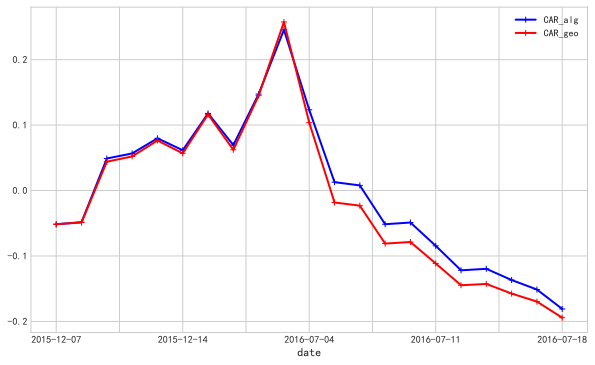

In [449]:
# 可以任意画一个固定事件（没被筛除）的情况
# 为了检验是否计算正确，仍然取万科A和上面的结果进行对比
trial = result[result['event_id'] == 5]
trial.set_index('date', inplace=True)
# plotCAR_avg(trial)
# plotCAR_geo(trial)
trial['CAR_alg'] = trial['abnormal'].cumsum()
trial['CAR_geo'] = (1+trial['abnormal']).cumprod()-1
trial[['CAR_alg', 'CAR_geo']].plot(kind='line', figsize=(10,6), color=['b', 'r'], marker='+')
plt.savefig("./figures/event5.png", dpi=800)

<AxesSubplot:xlabel='date'>

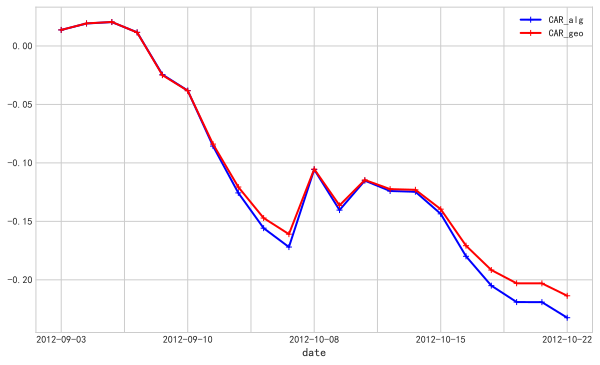

In [447]:
# 可以任意画一个固定事件（没被筛除）的情况
# 例如event 11，典型的负影响
trial = result[result['event_id'] == 11]
trial.set_index('date', inplace=True)
# plotCAR_avg(trial)
# plotCAR_geo(trial)
trial['CAR_alg'] = trial['abnormal'].cumsum()
trial['CAR_geo'] = (1+trial['abnormal']).cumprod()-1
trial[['CAR_alg', 'CAR_geo']].plot(kind='line', figsize=(10,6), color=['b', 'r'], marker='+')
plt.savefig("./figures/event11.png", dpi=800)

<AxesSubplot:xlabel='date'>

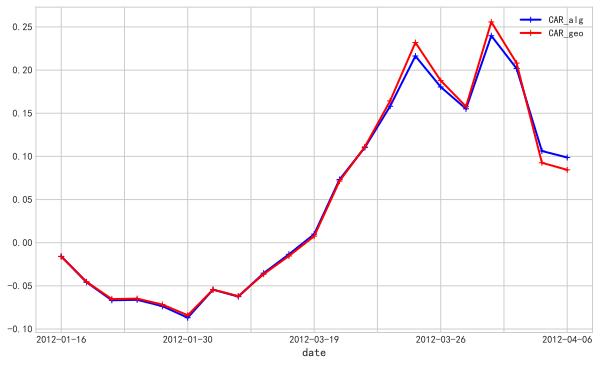

In [448]:
# 可以任意画一个固定事件（没被筛除）的情况
# 例如event 15，典型的正向股价影响
trial = result[result['event_id'] == 16]
trial.set_index('date', inplace=True)
# plotCAR_avg(trial)
# plotCAR_geo(trial)
trial['CAR_alg'] = trial['abnormal'].cumsum()
trial['CAR_geo'] = (1+trial['abnormal']).cumprod()-1
trial[['CAR_alg', 'CAR_geo']].plot(kind='line', figsize=(10,6), color=['b', 'r'], marker='+')
plt.savefig("./figures/event16.png", dpi=800)


#### **计算全市场平均**

**计算全市场的平均值时，我需要对每个事件前后给予一个label，每个事件的片段长度应该是21，但是apply一直报错，仔细查看发现，竟然有一个事件只有十一条数据，按理是不应该出现的情况。具体查看后发现是945号定向增发：招商蛇口（001979）招商蛇口于2015年12月31日起才有交易数据，但其定向增发公告日为 2015年9月18日，因此缺失公告日前十交易日的数据。其由于公告日前所有数据都是没有的，反而在一系列slicing的操作中没有报错。需要额外剔除。**

In [10]:
result

,event_id,date,abnormal,volume,notional,mv,c_mv
0,0,2010-06-10,-0.016394,28464074.0,4.895631e+08,5.313397e+10,5.003172e+10
1,0,2010-06-11,-0.010944,20998339.0,3.622928e+08,5.325819e+10,5.014868e+10
2,0,2010-06-18,0.015981,44849256.0,7.852488e+08,5.378611e+10,5.064579e+10
3,0,2010-06-21,0.005336,58980712.0,1.063389e+09,5.682944e+10,5.351142e+10
4,0,2010-06-22,0.009125,41713771.0,7.704887e+08,5.754369e+10,5.418397e+10
...,...,...,...,...,...,...,...
82767,3941,2020-01-09,0.011149,2315501.0,1.192725e+08,5.161000e+09,1.290250e+09
82768,3941,2020-01-10,0.001346,2415552.0,1.249473e+08,5.165000e+09,1.291250e+09
82769,3941,2020-01-13,-0.000554,2320456.0,1.205098e+08,5.202000e+09,1.300500e+09
82770,3941,2020-01-14,0.019503,4531454.0,2.405577e+08,5.346000e+09,1.336500e+09


In [11]:
def label(df):
    df['index'] = np.arange(21)-10
    return df
a = result.groupby(['event_id'])['abnormal'].size()
a

event_id
0       21
1       21
2       21
3       21
4       21
        ..
3937    21
3938    21
3939    21
3940    21
3941    21
Name: abnormal, Length: 3942, dtype: int64

In [12]:
a.value_counts()

21    3941
11       1
Name: abnormal, dtype: int64

In [13]:
a[a.values == 11]

event_id
945    11
Name: abnormal, dtype: int64

In [14]:
event[event['event_id'] == 945]

,code,short,full,date,event_id
945,001979,招商蛇口,招商局蛇口工业区控股股份有限公司,2015-09-18,945


In [15]:
result[result['event_id'] == 945]

,event_id,date,abnormal,volume,notional,mv,c_mv
19845,945,2015-12-30,-0.080129,514881291.0,1.153334e+10,1.715737e+11,4.404747e+10
19846,945,2015-12-31,-0.100439,280182975.0,5.993871e+09,1.544015e+11,3.963892e+10
19847,945,2016-01-04,0.021978,153340796.0,3.074335e+09,1.452973e+11,3.730163e+10
19848,945,2016-01-05,-0.026085,162408318.0,3.170523e+09,1.443351e+11,3.705460e+10
19849,945,2016-01-06,0.022587,124426109.0,2.388081e+09,1.444091e+11,3.707360e+10
19850,945,2016-01-07,-0.007448,31612343.0,5.827906e+08,1.304937e+11,3.350116e+10
19851,945,2016-01-08,-0.028900,153606261.0,2.654856e+09,1.260526e+11,3.236102e+10
19852,945,2016-01-11,-0.042508,151853020.0,2.420680e+09,1.134696e+11,2.913062e+10
19853,945,2016-01-12,0.023915,140577303.0,2.257678e+09,1.197611e+11,3.074582e+10
19854,945,2016-01-13,0.018190,116056754.0,1.905178e+09,1.280463e+11,2.862499e+10


In [16]:
# 删除招商蛇口的异常数据
result = result[result['event_id'] != 945]
def label(df):
    df['index'] = np.arange(21)-10
    return df['index']
tmp = result.copy()
tmp.set_index('event_id', inplace=True)
tmp = result.groupby(['event_id']).apply(label)
tmp = pd.DataFrame(tmp)
tmp

index
event_id             
0        0        -10
         1         -9
         2         -8
         3         -7
         4         -6
...               ...
3941     82767      6
         82768      7
         82769      8
         82770      9
         82771     10

[82761 rows x 1 columns]

In [17]:
tmp

index
event_id             
0        0        -10
         1         -9
         2         -8
         3         -7
         4         -6
...               ...
3941     82767      6
         82768      7
         82769      8
         82770      9
         82771     10

[82761 rows x 1 columns]

In [18]:
result

,event_id,date,abnormal,volume,notional,mv,c_mv
0,0,2010-06-10,-0.016394,28464074.0,4.895631e+08,5.313397e+10,5.003172e+10
1,0,2010-06-11,-0.010944,20998339.0,3.622928e+08,5.325819e+10,5.014868e+10
2,0,2010-06-18,0.015981,44849256.0,7.852488e+08,5.378611e+10,5.064579e+10
3,0,2010-06-21,0.005336,58980712.0,1.063389e+09,5.682944e+10,5.351142e+10
4,0,2010-06-22,0.009125,41713771.0,7.704887e+08,5.754369e+10,5.418397e+10
...,...,...,...,...,...,...,...
82767,3941,2020-01-09,0.011149,2315501.0,1.192725e+08,5.161000e+09,1.290250e+09
82768,3941,2020-01-10,0.001346,2415552.0,1.249473e+08,5.165000e+09,1.291250e+09
82769,3941,2020-01-13,-0.000554,2320456.0,1.205098e+08,5.202000e+09,1.300500e+09
82770,3941,2020-01-14,0.019503,4531454.0,2.405577e+08,5.346000e+09,1.336500e+09


In [19]:
# 重设索引做匹配
tmp.reset_index(inplace=True)
tmp.set_index('event_id', inplace=True)
result.sort_values(['event_id', 'date'], inplace=True)
result.set_index('event_id', inplace=True)
result['index'] = tmp['index']
result.reset_index(inplace=True)

result.to_csv("./processed_data/abnormal_return_with_index.csv", index=False, columns=['event_id', 'index', 'date', 'abnormal'])
result

,event_id,date,abnormal,volume,notional,mv,c_mv,index
0,0,2010-06-10,-0.016394,28464074.0,4.895631e+08,5.313397e+10,5.003172e+10,-10
1,0,2010-06-11,-0.010944,20998339.0,3.622928e+08,5.325819e+10,5.014868e+10,-9
2,0,2010-06-18,0.015981,44849256.0,7.852488e+08,5.378611e+10,5.064579e+10,-8
3,0,2010-06-21,0.005336,58980712.0,1.063389e+09,5.682944e+10,5.351142e+10,-7
4,0,2010-06-22,0.009125,41713771.0,7.704887e+08,5.754369e+10,5.418397e+10,-6
...,...,...,...,...,...,...,...,...
82756,3941,2020-01-09,0.011149,2315501.0,1.192725e+08,5.161000e+09,1.290250e+09,6
82757,3941,2020-01-10,0.001346,2415552.0,1.249473e+08,5.165000e+09,1.291250e+09,7
82758,3941,2020-01-13,-0.000554,2320456.0,1.205098e+08,5.202000e+09,1.300500e+09,8
82759,3941,2020-01-14,0.019503,4531454.0,2.405577e+08,5.346000e+09,1.336500e+09,9


In [96]:
# 前面加上一个0，以0为基准计算
output = result.groupby('index')[['abnormal']].mean()
output.loc[-11, 'abnormal'] = 0
output.sort_index(inplace=True)
output

,abnormal
index,
-11,0.000000
-10,-0.003444
-9,-0.004444
-8,-0.004776
-7,-0.004315
-6,-0.004419
-5,-0.004474
-4,-0.004814
-3,-0.004516


<AxesSubplot:xlabel='index'>

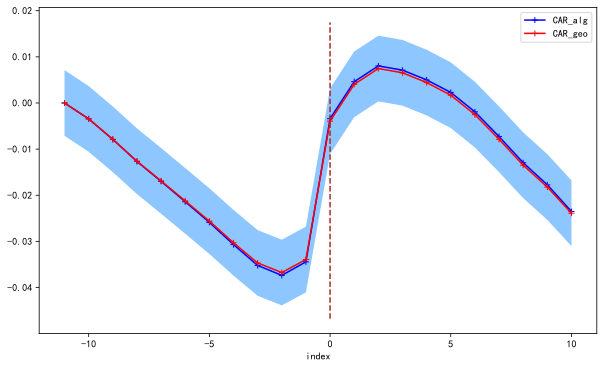

In [22]:
output['CAR_alg'] = output['abnormal'].cumsum()
output['CAR_geo'] = (1+output['abnormal']).cumprod()-1
output[['CAR_alg', 'CAR_geo']].plot(kind='line', figsize=(10,6), color=['b', 'r'], marker='+')
plt.plot([0, 0], [output['CAR_geo'].min()-0.01, output['CAR_geo'].max()+0.01], '--', c='brown')
lower = np.array(output['CAR_geo']) + 0.5*output['CAR_geo'].std()
upper = np.array(output['CAR_geo']) - 0.5*output['CAR_geo'].std()
plt.fill_between(x=output['CAR_alg'].index, y1=lower, y2=upper, facecolor="dodgerblue", alpha=0.5)
plt.savefig("./figures/final_result.png", dpi=800)

**进一步可根据已有因子进行分析，例如对流通市值分为十个组合探究**

In [24]:
# 根据公告日当日的市值划分

# 取出公告日当日的因子值
factor = result[result['index'] == 0][['event_id', 'volume', 'notional', 'mv', 'c_mv']]
factor

,event_id,volume,notional,mv,c_mv
10,0,163454210.0,2.984709e+09,6.339240e+10,5.648681e+10
31,1,14681599.0,2.193402e+08,7.638915e+10,4.630090e+10
52,2,220449384.0,2.639382e+09,9.943398e+10,6.026916e+10
73,3,61770283.0,5.924315e+08,1.097932e+11,6.430164e+10
94,4,59803634.0,7.474872e+08,1.795739e+11,1.481411e+11
...,...,...,...,...,...
82666,3937,2704012.0,8.504447e+07,4.173120e+09,1.043280e+09
82687,3938,4457130.0,8.285595e+07,3.825072e+09,9.562680e+08
82708,3939,1925007.0,2.669985e+07,2.845700e+09,7.115310e+08
82729,3940,1925007.0,2.669985e+07,2.845700e+09,7.115310e+08


In [27]:
# 超参数
groups = 10

# 以流通市值为例，可以随意改成其他
factor['rank'] = factor['c_mv'].rank(pct=True)

# cut函数一键分组
factor['group'] = pd.cut(x=factor['rank'], bins=np.linspace(0, 1, num=groups+1), include_lowest=True, labels=(np.arange(groups)+1)).astype(int)
factor

,event_id,volume,notional,mv,c_mv,rank,group
10,0,163454210.0,2.984709e+09,6.339240e+10,5.648681e+10,0.992134,10
31,1,14681599.0,2.193402e+08,7.638915e+10,4.630090e+10,0.988835,10
52,2,220449384.0,2.639382e+09,9.943398e+10,6.026916e+10,0.993149,10
73,3,61770283.0,5.924315e+08,1.097932e+11,6.430164e+10,0.994164,10
94,4,59803634.0,7.474872e+08,1.795739e+11,1.481411e+11,0.998985,10
...,...,...,...,...,...,...,...
82666,3937,2704012.0,8.504447e+07,4.173120e+09,1.043280e+09,0.057600,1
82687,3938,4457130.0,8.285595e+07,3.825072e+09,9.562680e+08,0.045166,1
82708,3939,1925007.0,2.669985e+07,2.845700e+09,7.115310e+08,0.021441,1
82729,3940,1925007.0,2.669985e+07,2.845700e+09,7.115310e+08,0.021441,1


In [29]:
# 将分组结果与大表合并
mkt = result.copy()
mkt.set_index('event_id', inplace=True)
mkt['group'] = factor.set_index('event_id')['group']
mkt

,date,abnormal,volume,notional,mv,c_mv,index,group
event_id,,,,,,,,
0,2010-06-10,-0.016394,28464074.0,4.895631e+08,5.313397e+10,5.003172e+10,-10,10
0,2010-06-11,-0.010944,20998339.0,3.622928e+08,5.325819e+10,5.014868e+10,-9,10
0,2010-06-18,0.015981,44849256.0,7.852488e+08,5.378611e+10,5.064579e+10,-8,10
0,2010-06-21,0.005336,58980712.0,1.063389e+09,5.682944e+10,5.351142e+10,-7,10
0,2010-06-22,0.009125,41713771.0,7.704887e+08,5.754369e+10,5.418397e+10,-6,10
...,...,...,...,...,...,...,...,...
3941,2020-01-09,0.011149,2315501.0,1.192725e+08,5.161000e+09,1.290250e+09,6,1
3941,2020-01-10,0.001346,2415552.0,1.249473e+08,5.165000e+09,1.291250e+09,7,1
3941,2020-01-13,-0.000554,2320456.0,1.205098e+08,5.202000e+09,1.300500e+09,8,1


In [60]:
# 对组内abnormal return求均值
ret = mkt.groupby(['group', 'index'])[['abnormal']].mean()
ret.head(10)

abnormal
group index          
1     -10    0.002697
      -9    -0.009684
      -8    -0.006853
      -7    -0.005273
      -6    -0.004199
      -5    -0.006535
      -4    -0.006482
      -3    -0.003831
      -2    -0.003520
      -1     0.001065

In [62]:
# 例如只根据一层level=0级的索引去slicing
ret.loc[(1, slice(None)), ]

abnormal
group index          
1     -10    0.002697
      -9    -0.009684
      -8    -0.006853
      -7    -0.005273
      -6    -0.004199
      -5    -0.006535
      -4    -0.006482
      -3    -0.003831
      -2    -0.003520
      -1     0.001065
       0     0.062000
       1     0.026027
       2     0.018327
       3     0.008296
       4     0.001990
       5     0.002385
       6    -0.004490
       7    -0.004838
       8    -0.001660
       9    -0.002762
       10   -0.006323

In [63]:
# 调用双重索引给每个group加上初始值0
for group in range(groups):
    ret.loc[(group+1, slice(None)), 'CAR_alg'] = ret.loc[(group+1, slice(None)), 'abnormal'].cumsum()
    ret.loc[(group+1, slice(None)), 'CAR_geo'] = (1+ret.loc[(group+1, slice(None)), 'abnormal']).cumprod()-1
    # 赋值
    ret.loc[(group+1, -11), 'abnormal'] = 0
    ret.loc[(group+1, -11), 'CAR_alg'] = 0
    ret.loc[(group+1, -11), 'CAR_geo'] = 0
    # double index排序
    ret.sort_index(level=(0,1), inplace=True)
ret.head(10)

abnormal   CAR_alg   CAR_geo
group index                              
1     -11    0.000000  0.000000  0.000000
      -10    0.002697  0.002697  0.002697
      -9    -0.009684 -0.006986 -0.007013
      -8    -0.006853 -0.013840 -0.013818
      -7    -0.005273 -0.019113 -0.019018
      -6    -0.004199 -0.023312 -0.023138
      -5    -0.006535 -0.029847 -0.029521
      -4    -0.006482 -0.036329 -0.035812
      -3    -0.003831 -0.040160 -0.039506
      -2    -0.003520 -0.043681 -0.042887

In [66]:
ret.reset_index(inplace=True)
ret.head(10)

,group,index,abnormal,CAR_alg,CAR_geo
0,1,-11,0.000000,0.000000,0.000000
1,1,-10,0.002697,0.002697,0.002697
2,1,-9,-0.009684,-0.006986,-0.007013
3,1,-8,-0.006853,-0.013840,-0.013818
4,1,-7,-0.005273,-0.019113,-0.019018
5,1,-6,-0.004199,-0.023312,-0.023138
6,1,-5,-0.006535,-0.029847,-0.029521
7,1,-4,-0.006482,-0.036329,-0.035812
8,1,-3,-0.003831,-0.040160,-0.039506
9,1,-2,-0.003520,-0.043681,-0.042887


In [84]:
ret['group'].value_counts()

1     22
2     22
3     22
4     22
5     22
6     22
7     22
8     22
9     22
10    22
Name: group, dtype: int64

In [ ]:
seaborn-whitegrid

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='index', ylabel='CAR_alg'>

(-12.0, 13.0)

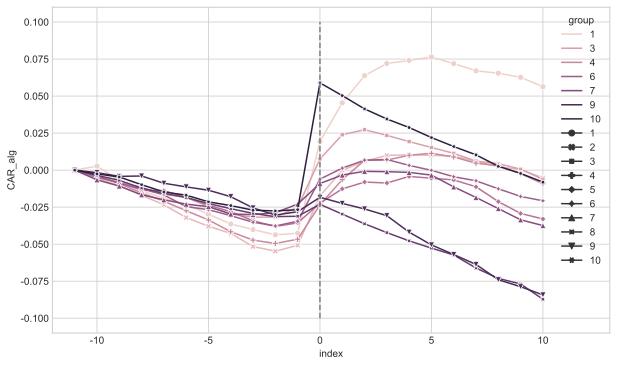

In [118]:
# 使用seaborn，为啥tm不给我画confidence interval？
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))
# hue参数使得不同组颜色不同，style参数使得linestyle不同
sns.lineplot(data=ret, x='index', y='CAR_alg', hue='group', style='group', markers=True, dashes=False)
plt.xlim(-12, 13)
plt.plot([0, 0], [-0.1, 0.1], '--', c='grey')
plt.savefig("./figures/group_by_circulate.png", dpi=800)

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

(-12.0, 12.4)

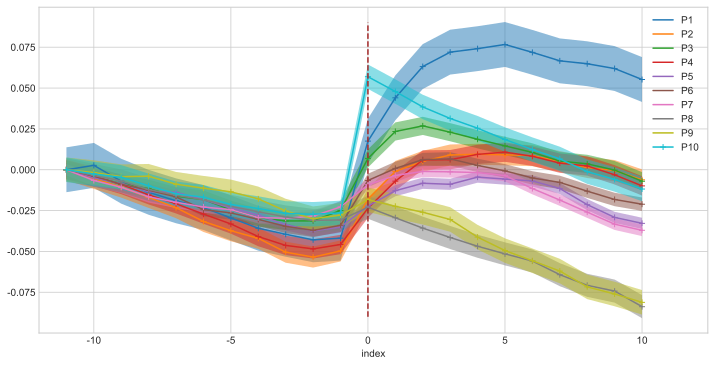

In [133]:
# 手动画一遍带CI的，首先是恒宽度的CI，0.3倍标准差（自己调）
figure = plt.figure(figsize=(12,6))
ax = figure.add_subplot(1, 1, 1)
for i in range(groups):
    output = ret[ret['group'] == i+1]
    output.set_index('index', inplace=True)
    output.rename(columns={'CAR_geo': 'P%s'%(i+1)}, inplace=True)
    output[['P%s'%(i+1)]].plot(kind='line', marker='+', ax=ax)
    lower = np.array(output['P%s'%(i+1)]) + 0.3*output['P%s'%(i+1)].std()
    upper = np.array(output['P%s'%(i+1)]) - 0.3*output['P%s'%(i+1)].std()
    plt.fill_between(x=output['P%s'%(i+1)].index, y1=lower, y2=upper, alpha=0.5)
plt.xlim(-12, 12.4)
plt.plot([0, 0], [-0.09, 0.09], '--', c='brown')
plt.savefig("./figures/group_by_circulate_with_const_CI.png", dpi=800)

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

(-12.0, 12.4)

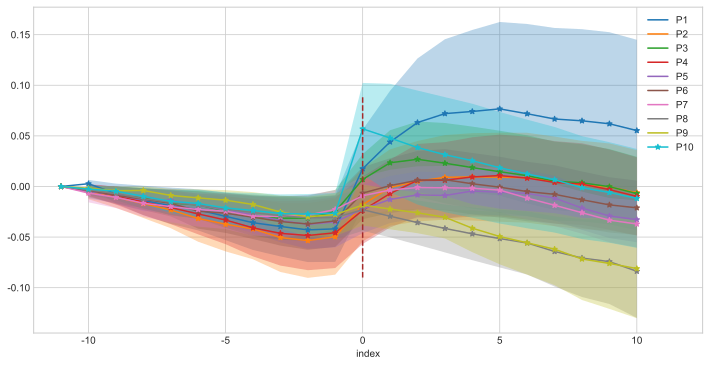

In [145]:
# 手动画一遍带CI的，这次是rolling的CI
# 大面积重叠的话就把阴影部分的透明度也就是alpha设置的低一点
figure = plt.figure(figsize=(12,6))
ax = figure.add_subplot(1, 1, 1)
for i in range(groups):
    output = ret[ret['group'] == i+1]
    output.set_index('index', inplace=True)
    output.rename(columns={'CAR_geo': 'P%s'%(i+1)}, inplace=True)
    output[['P%s'%(i+1)]].plot(kind='line', marker='*', ax=ax)
    lower = np.array(output['P%s'%(i+1)]) + 1.96*output['P%s'%(i+1)].expanding(min_periods=1).std()
    upper = np.array(output['P%s'%(i+1)]) - 1.96*output['P%s'%(i+1)].expanding(min_periods=1).std()
    plt.fill_between(x=output['P%s'%(i+1)].index, y1=lower, y2=upper, alpha=0.3)
plt.xlim(-12, 12.4)
plt.plot([0, 0], [-0.09, 0.09], '--', c='brown')
plt.savefig("./figures/group_by_circulate_with_rolling_CI_1.96.png", dpi=800)

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

<AxesSubplot:xlabel='index'>

(-12.0, 12.4)

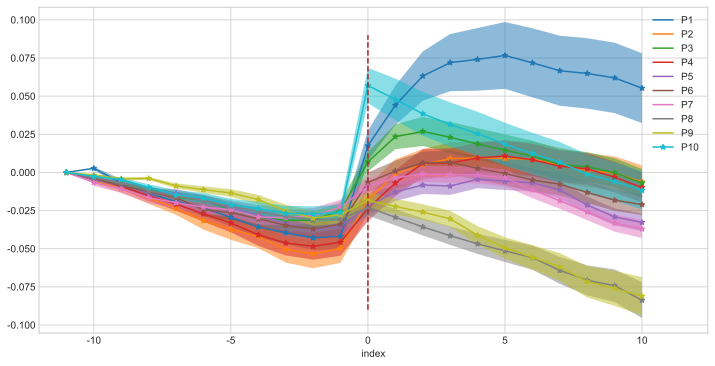

In [146]:
# 改一下宽度，宽度变窄，阴影alpha也调高一点
figure = plt.figure(figsize=(12,6))
ax = figure.add_subplot(1, 1, 1)
for i in range(groups):
    output = ret[ret['group'] == i+1]
    output.set_index('index', inplace=True)
    output.rename(columns={'CAR_geo': 'P%s'%(i+1)}, inplace=True)
    output[['P%s'%(i+1)]].plot(kind='line', ax=ax, marker='*')
    lower = np.array(output['P%s'%(i+1)]) + 0.5*output['P%s'%(i+1)].expanding(min_periods=1).std()
    upper = np.array(output['P%s'%(i+1)]) - 0.5*output['P%s'%(i+1)].expanding(min_periods=1).std()
    plt.fill_between(x=output['P%s'%(i+1)].index, y1=lower, y2=upper, alpha=0.5)
plt.xlim(-12, 12.4)
plt.plot([0, 0], [-0.09, 0.09], '--', c='brown')
plt.savefig("./figures/group_by_circulate_with_rolling_CI_0.5.png", dpi=800)